In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time

In [2]:
#Ultimately decided to also do a bit of mdoeling here...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV, RFE

In [3]:
df = pd.read_csv('../data/chicago_taxis_ii.csv') #In short, we're doing this. See Readme.
print(df.shape)
df.head()

(38349, 13)


,taxi_id,trip_start_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company
0,008dda45db57cb6daa679a86ce8c8149ddc05446d545b1...,2015-01-14 14:30:00.000000 UTC,321,0.9,32.0,32.0,5.65,1.00,NaN,0.0,6.65,Credit Card,Yellow Cab
1,008dda45db57cb6daa679a86ce8c8149ddc05446d545b1...,2015-01-16 03:30:00.000000 UTC,688,4.2,24.0,22.0,12.25,2.45,NaN,0.0,14.70,Credit Card,Yellow Cab
2,008dda45db57cb6daa679a86ce8c8149ddc05446d545b1...,2015-01-01 01:30:00.000000 UTC,781,3.9,4.0,6.0,11.65,2.91,NaN,0.0,14.56,Credit Card,Yellow Cab
3,008dda45db57cb6daa679a86ce8c8149ddc05446d545b1...,2015-01-24 06:00:00.000000 UTC,104,0.4,6.0,6.0,3.85,15.71,NaN,0.0,19.56,Credit Card,Yellow Cab
4,008dda45db57cb6daa679a86ce8c8149ddc05446d545b1...,2015-01-06 22:00:00.000000 UTC,176,0.8,6.0,6.0,4.85,1.00,NaN,0.0,5.85,Credit Card,Yellow Cab


In [4]:
df['company'].value_counts() #Wow, despite trying to grab 40k guys (38.3k per the 10 mb download limit) we still just hav
#Yellow cab. Hmm... Yeah, we'll drop this column. I still want to examine cross-company business, but likely the human element,
#the part that's truly worthy of a 'tip', if at all, is best exemplifid here. So, let us finally be satisifed with this dataset
#and continue.

company
Yellow Cab    38349
Name: count, dtype: int64

In [5]:
print(df.shape[0]/(len(df['taxi_id'].unique())*31)) #Hmm, so the average taxi driver is giving six rides a day. Keep this in mind for later.

5.947425558312655


In [6]:
#On principal I'll redo all of the coding checks I usually do, yet I'll save commentary for something new.
df.columns

Index(['taxi_id', 'trip_start_timestamp', 'trip_seconds', 'trip_miles',
       'pickup_community_area', 'dropoff_community_area', 'fare', 'tips',
       'tolls', 'extras', 'trip_total', 'payment_type', 'company'],
      dtype='object')

In [7]:
print(df.isnull().sum()) #Oh wow... all of the tolls are nulls... looks like we'll just be dropping that column then.

#Yeah, let's go ahead and borrow inspiration from the below code and go ahead and knock out a totally nulled row...
    #Perhaps a fail safe if that's the target variable? Nah, I don't care what the board says - if the target is null...
    #they're dull and drop them.

for i in df.columns:
    if df[i].isnull().sum() == df.shape[0]:
        df = df.drop([i], axis=1)
        print(f"Hence we just dropped {i} as sadly, without exception, that entire column was nulled...")

taxi_id                       0
trip_start_timestamp          0
trip_seconds                  0
trip_miles                    0
pickup_community_area       342
dropoff_community_area     1261
fare                          0
tips                          0
tolls                     38349
extras                        0
trip_total                    0
payment_type                  0
company                       0
dtype: int64
Hence we just dropped tolls as sadly, without exception, that entire column was nulled...


In [8]:
#Added a new feature to also take care of 1 dimensional fields - no need to keep those.

for i in df.columns:
    if len(df[i].unique()) == df.shape[0] or len(df[i].unique()) == 1:
        df = df.drop([i], axis=1) #Not adding anything to our model... Hmm, now that I think about it, let's make this better:
        print(f"Just dropped {i} as it wasn't adding any value whatsoever to our model.")
    else:
        print(f"Well, {i} has {len(df[i].unique())} unique fields, so we'll keep it...for now!")

Well, taxi_id has 208 unique fields, so we'll keep it...for now!
Well, trip_start_timestamp has 2907 unique fields, so we'll keep it...for now!
Well, trip_seconds has 3137 unique fields, so we'll keep it...for now!
Well, trip_miles has 325 unique fields, so we'll keep it...for now!
Well, pickup_community_area has 68 unique fields, so we'll keep it...for now!
Well, dropoff_community_area has 73 unique fields, so we'll keep it...for now!
Well, fare has 313 unique fields, so we'll keep it...for now!
Well, tips has 906 unique fields, so we'll keep it...for now!
Well, extras has 81 unique fields, so we'll keep it...for now!
Well, trip_total has 1665 unique fields, so we'll keep it...for now!
Well, payment_type has 2 unique fields, so we'll keep it...for now!
Just dropped company as it wasn't adding any value whatsoever to our model.


In [9]:
df['taxi_id'] = df['taxi_id'].replace(list(df['taxi_id'].unique()),[f"taxi_{i}" for i in range(df['taxi_id'].unique().shape[0])])

df['start_date'] = pd.to_datetime(df['trip_start_timestamp']).dt.date
df['start_time'] = pd.to_datetime(df['trip_start_timestamp']).dt.time

df = df.drop(['trip_start_timestamp'], axis = 1)

In [10]:
print(df['trip_seconds'].isnull().sum()/df.shape[0])
#print(df[df['trip_seconds'].isnull()]['trip_miles'].describe())
#df['trip_seconds'].replace(np.nan,0.0, inplace=True)
print(df[df['trip_seconds']==0].shape[0]/df.shape[0])
df['trip_seconds'].describe()

0.0
0.0


count    38349.000000
mean       817.502047
std        642.643298
min          1.000000
25%        388.000000
50%        614.000000
75%       1043.000000
max       8319.000000
Name: trip_seconds, dtype: float64

Now there we go! Still skewed to the right, but a lot more of what I'd expect with actual taxi rides! Ie an over 10 minute median and 13 minute mean taxi ride... sounds a lot more realistic. 

In [11]:
print(df['trip_miles'].isnull().sum()/df.shape[0])
#print(df[df['trip_miles'].isnull()]['trip_seconds'].describe())
#df['trip_miles'].replace(np.nan,0.0, inplace=True)
print(df[df['trip_miles']==0].shape[0]/df.shape[0])
df['trip_miles'].describe()

0.0
0.0


count    38349.000000
mean         4.729565
std          5.610072
min          0.100000
25%          1.100000
50%          2.200000
75%          5.500000
max         63.400000
Name: trip_miles, dtype: float64

Similarily, trip miles seem reasonble. Of interest would be to consider factors such as location re traffic and the like as notice that here the mean is more than half of the mean!

In [12]:
print(df[df['pickup_community_area'].notnull()].shape[0])
print(df[df['dropoff_community_area'].notnull()].shape[0])
print(len(df['pickup_community_area'].unique()), len(df['dropoff_community_area'].unique())) #Counting nulls

38007
37088
68 73


In [13]:
df['fare'].describe()

count    38349.000000
mean        12.987318
std         10.375461
min          3.250000
25%          6.050000
50%          8.450000
75%         14.850000
max        117.650000
Name: fare, dtype: float64

Continuing the theme of right skews, yet reasonable. Quite happy with this.

HOWEVER, bear in mind that this will be correlated, likely, with miles and times - the main (if not only) calculations of the factor, save perhaps a base pick-up fare.

In [14]:
#Saving tips for later as that's our target...potentially.

df['extras'].describe() #Unsurprising as generally people don't have extras like vomit-cleaning fees...

count    38349.000000
mean         0.859318
std          2.239966
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         99.500000
Name: extras, dtype: float64

In [15]:
df['trip_total'].describe()

count    38349.000000
mean        16.760136
std         13.620977
min          3.650000
25%          8.450000
50%         11.050000
75%         18.150000
max        300.850000
Name: trip_total, dtype: float64

Completely unsurprising that this also skewed o the right as seemingly this is jut a simple add. Yet a precise add does not yield the same results for a bit less than 10% of the cases (below). However, this seems to be via rounding errors as look at the head - row 4's far of 3.85 and tip of 15.71 equals 19.56....yet via rounding in one of the features it's not precisely the same. However, plus or minus a penny we have no excepetions - so yes, trip_total is a function of those three.

For later prediction purposes, it won't behoove us to keep trip_total unadjusted as it already includes our target - the fare. So, we'll change it to remove the fare momentarily.

In [16]:
print(df[df['trip_total'] != df['fare'] + df['tips'] + df['extras']].shape[0])

print(df[~df['trip_total'].between(df['fare'] + df['tips'] + df['extras']-.01,df['fare'] + df['tips'] + df['extras']+.01)].shape[0])

df['trip_total_pre_tip'] = df['trip_total'] - df['tips']

df = df.drop(['trip_total'], axis = 1) #Moving to later on

3522
0


In [17]:
df['payment_type'].value_counts(normalize=0)

payment_type
Credit Card    38342
Cash               7
Name: count, dtype: int64

 Oh wow... I didn't realize that many people use credi cards (in 2015). Wow, a bit tempted to just drop this column when so few people use cash. To do things justice, I'll at least look at them first (even though in conjunction with the consideration of other factors cash might contriubte to tipping less (or technically the reverse), per the small sample we have...

In [18]:
df.groupby('payment_type')['tips'].describe()

,count,mean,std,min,25%,50%,75%,max
payment_type,,,,,,,,
Cash,7.0,3.242857,4.101060,0.05,1.00,1.0,4.2,11.25
Credit Card,38342.0,2.913440,2.739069,0.01,1.99,2.0,3.0,270.00


Oh wow, the mean of cash is a bit higher; median on the other hand... However, with such few results I think I'll ignore this column.

In [19]:
df = df.drop(['payment_type'], axis = 1) #Potentially I wonder if we should just remove the cash ons, but eh...

Oooh date. On the topic - recall that we're in the month of January, a typically cold month in Chicago (without examining what actually happened, but statistically...). As far as I know, nothing stands out re. 2015... However, the weekend factor might contribute to matters, assuming most people have off Saturday and on Sunday (and on that note Friday evening, say after 19, should likely also be considered an evening...

So, it's incumbent upon us to make day-of-the-week guys. I'll preserve the original in case we need it; eh, we still have our dataset... On that note, it might be interesting to make nighttime/daytime variables.

From a time series perspective I think a month's change is negligible of changes in culture, inflation, etc. However, around the clock could provide an interesting perspective.

For this first analysis we'll go about things normally, but we might as well arrange things later by time. Note then that we'd need to average all of the features together, potentially going back to SQL to do so.

In [20]:
df['day_of_week'] = pd.to_datetime(df['start_date']).dt.day_name()

In [21]:
#For now at least let's just make things simple and assign anything on Saturday or Sunday to be the weekend
df['weekend'] = [1 if i in ['Saturday','Sunday'] else 0 for i in df['day_of_week']]

# df.iloc[0, df.columns.get_loc('start_time')] > time(17,00)

In [22]:
# df['start_time'] = pd.to_datetime(df['start_time'], format='%H:%M')

In [23]:
#A final initial time manipulation I'll do is to if the taxi service started during the day or not. 
#January 15th in Chicago, per a quite google search, lists 7:15 and 16:45 as sunrise/set. I'll rely on this, not wanting to change
#from day to day. Furthermore, unsure which direction to be "strict" in, as I'm unsure if people are in greater moods during
#the day or at night.

#on the topic, a bit of a reief we're doing this just in January/one month as this factor would change over time;
#hence the desire to do a timeseries noob.

df['night'] = [1 if (i < time(7,15)) or (i > time(16,45)) else 0 for i in df['start_time']]

#Should be done with these for now.
df = df.drop(['day_of_week', 'start_date', 'start_time'], axis = 1)

In [24]:
#The final matter to consider is our target: tips. I'm unsure if I should keep them in dollar amounts or a percentage of the pre-tip
#fare. I'm inclined the later as I think it'll be more robust to large trips as well as more descriptive of behavior overall...

#Would like to right on this more later, but eh...

df['tip_percentage'] = df['tips'] / df['trip_total_pre_tip']

df = df.drop(['tips', 'trip_total_pre_tip'], axis = 1) #Given that it's a simple add of the previous two, it's not contributing
#anything else anymore to having it. So, let us retain our individual fares and extras.

In [25]:
#Great,we should be ready for actual modeling round, at least with this round:

#We'll also drop taxi id for now... Oh, and pickup/dropoff as I totally forgot about those two....
X = df.drop(['tip_percentage', 'taxi_id', 'pickup_community_area', 'dropoff_community_area'], axis=1)
y = df['tip_percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=26)
#Re. 26 - I like that number. Discussion not for now

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [26]:
lr = LinearRegression()

current_model = lr.fit(X_train, y_train)

current_preds = lr.predict(X_test)

print(current_model.score(X_train, y_train), current_model.score(X_test, y_test))
print(cross_val_score(lr, X_train, y_train, cv = 5).mean()) #Oh.... thats' horrible... albeit lr but stil...

0.039061156496955074 0.06738052175978615
0.06939697775750422


In [27]:
rf = RandomForestRegressor() #Without even tuning, let's at least get something....

current_model = rf.fit(X_train, y_train)

current_preds = rf.predict(X_test)

print(current_model.score(X_train, y_train), current_model.score(X_test, y_test))

0.8243585211010792 0.013231331983252992


Oh man.... that's even worse... So, we're obviously not giving up yet, but yeah... this is not looking good.

Then again, it could show you how whimsical tiping is and there's no trend in the tip percentage based upon this data.
NOW, pragmatically there's likely a trend between absolute dollars spend re. fare and trip, but at least re.percentage...

I'll at least look at some individual taxis before doing at least some type of regression...

Plus, it might be worthwhile to consider the rate of doing one big one versus many small ones... like all those taxi drivers that refused to make $20 to drive me a few blocks to the bus station lest a big whale get away and miss out on $200 when I was in Ukraine this past fall (2023).

In [28]:
df['tip_percentage'].describe()

count    38349.000000
mean         0.240101
std          0.186880
min          0.000260
25%          0.150376
50%          0.200000
75%          0.283688
max         21.739130
Name: tip_percentage, dtype: float64

In [29]:
#Hmm, this kinda seems like a sql thing. Oh well...
#In retrospect, I could bruteforce it here by making a loop to go through each unique taxi id, storing each one's value counts
#into a new df. For sure useful if I don't want to go back to SQL/didn't get the data from there.
print(len(df['taxi_id'].value_counts()))

taxi_id_df = df['taxi_id'].value_counts(ascending=False).reset_index()

df['taxi_id'].value_counts(ascending=False)[:10]

208


taxi_id
taxi_154    492
taxi_197    434
taxi_139    424
taxi_40     408
taxi_167    400
taxi_163    380
taxi_195    363
taxi_72     357
taxi_79     357
taxi_84     356
Name: count, dtype: int64

In [30]:
i = -1 #for browing purposes

In [31]:
i += 1

print(taxi_id_df.iloc[i])

df[df['taxi_id']==taxi_id_df.iloc[0,i]]['tip_percentage'].describe()

taxi_id    taxi_154
count           492
Name: 0, dtype: object


count    492.000000
mean       0.250750
std        0.111740
min        0.009266
25%        0.176991
50%        0.210532
75%        0.306527
max        0.854701
Name: tip_percentage, dtype: float64

At least describing the first taxi, who worked 492 trips, notice that his median type is higher. Perhaps due to his experience he knows how to give people a comfortable ride such that they want to tip more.

In full disclosure, given that this is a 'personal' project of sorts to preserve my Github activity. I can't say I'm interested in regular regression with a non-percentag based tip. I'll try to think of at least one more thing to do before calling it for this dataset (6/18/24).

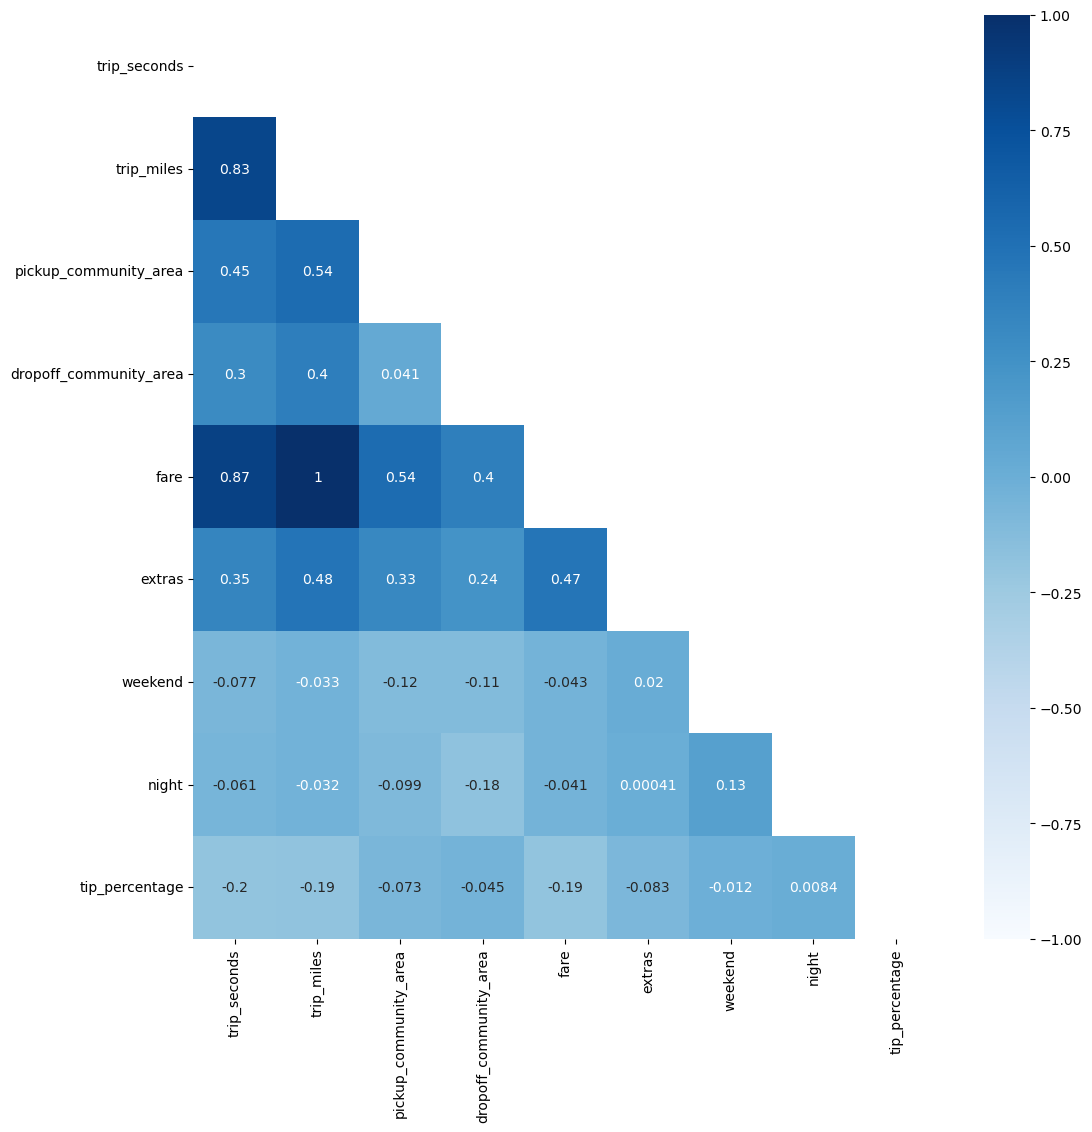

In [35]:
#Yeah, guess we'll do some more 'basic' things such as this:

plt.figure(figsize=(12, 12)) #
corr = df.corr(numeric_only=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, annot=True, vmin = -1, vmax = 1, cmap='Blues');

So, our true goal of tip percentage is pretty independent of everything. Of humour, to me at least, as the strongest correlation it has with something, albeit still weak, is having a negative .2 with the trip's duration. Ie it would imply that people are less likely to tip the longer the trip is (obviously factoring in matters such as expected trip duration. But, I can at least speak from my own experience that I'm less likely to tip as high when the trip as longer - as they at least made more base money from the longer trip (albeit the company might take whatever percentage...).

Wow, apparently fare is directly, 1, correlated with trip miles... eh, connsidring the time costs that shouldn't be.... Albeit we'd expect them to be high.So too with duration.

Of interest is the quite strong correlations we see between starting/ending location, whatever exactly is 'community_area' with duration and miles (and consquently fare). Ie their are likely relationships to be draw between the percentage of the people in all the areas as they go to their locations. Ie, sterotyping, all of Zone A are doctors that work in Zone B and the like.

Extras, whatever that vague term is, also interests me that it has such a strong correlation with the areas. Of interest is its weak correlation with duration and miles though.

Finally, our date features of weekend and night essentially are independent of anything (let alone our target). So, although I'm circumpsect to drop them, this would imply that they do not affect the model at all. For kicks I'll run the simple linear regression without them then call this project.

In [43]:
# df = df.drop(['weekend', 'night'], axis = 1) #Eh, should have just dropped it from X. Oh well.

X = df.drop(['tip_percentage', 'taxi_id', 'pickup_community_area', 'dropoff_community_area'], axis=1)
y = df['tip_percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=26)

lr = LinearRegression()

current_model = lr.fit(X_train, y_train)

current_preds = lr.predict(X_test)

print(current_model.score(X_train, y_train), current_model.score(X_test, y_test))
print(cross_val_score(lr, X_train, y_train, cv = 5).mean()) #Slightly worse, but eh...

0.03850262350730971 0.0654760985712608
0.06808583014129073


In [44]:
#Oh, no we have one more matter: the community areas... I just relaized that I didn't bother earlier to code for them.
df['pickup_community_area'].fillna(999, inplace=True)
df['dropoff_community_area'].fillna(999, inplace=True)

X = df.drop(['tip_percentage', 'taxi_id'], axis=1)
y = df['tip_percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=26)

lr = LinearRegression()

current_model = lr.fit(X_train, y_train)

current_preds = lr.predict(X_test)

print(current_model.score(X_train, y_train), current_model.score(X_test, y_test))
print(cross_val_score(lr, X_train, y_train, cv = 5).mean()) #A neglegible (sp?) increase, but worth a try.

0.03887235240840292 0.06579694259170499
0.0685738095707373


In [40]:
df.head()

,taxi_id,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,extras,tip_percentage
0,taxi_0,321,0.9,32.0,32.0,5.65,0.0,0.176991
1,taxi_0,688,4.2,24.0,22.0,12.25,0.0,0.200000
2,taxi_0,781,3.9,4.0,6.0,11.65,0.0,0.249785
3,taxi_0,104,0.4,6.0,6.0,3.85,0.0,4.080519
4,taxi_0,176,0.8,6.0,6.0,4.85,0.0,0.206186
